>>## Feelling Recognition NLP project using LSTM

In [227]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Dense , Dropout,LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
%matplotlib inline

In [9]:
len(open('data/test.txt','r').readlines())

2000

In [10]:
len(open('data/train.txt','r').readlines())

16000

In [11]:
len(open('data/val.txt','r').readlines())

2000

In [21]:
open('data/test.txt','r').readlines()[14]

'i find myself in the odd position of feeling supportive of;love\n'

In [20]:
open('data/train.txt','r').readlines()[14]

'i have immense sympathy with the general point but as a possible proto writer trying to find time to write in the corners of life and with no sign of an agent let alone a publishing contract this feels a little precious;joy\n'

In [19]:
open('data/val.txt','r').readlines()[14]

'i walked out of there an hour and fifteen minutes later feeling like i had been beaten with a stick and then placed on the rack and stretched;sadness\n'

## read the training data

In [50]:
with open('data/train.txt','r') as file:
    data = file.readlines()
    print(data)

['i didnt feel humiliated;sadness\n', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness\n', 'im grabbing a minute to post i feel greedy wrong;anger\n', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love\n', 'i am feeling grouchy;anger\n', 'ive been feeling a little burdened lately wasnt sure why that was;sadness\n', 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny;surprise\n', 'i feel as confused about life as a teenager or as jaded as a year old man;fear\n', 'i have been with petronas for years i feel that petronas has performed well and made a huge profit;joy\n', 'i feel romantic too;love\n', 'i feel like i have to make the suffering i m seeing mean something;sadness\n', 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter;joy\n', 'i think 

In [51]:
x = []
y = []
for i in range(len(open('data/train.txt','r').readlines())):
    splited = data[i].split(';')
    x.append(splited[0])
    y.append(splited[1])    

In [40]:
x[1]

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

In [43]:
y[1]

'sadness\n'

In [45]:
len(x),len(y)    # i got the x and y data

(16000, 16000)

In [52]:
for i in range(len(open('data/train.txt','r').readlines())):
    cleaned = y[i].replace('\n','')
    y[i] = cleaned

In [48]:
y[1]       # i cleaned the y data

'sadness'

In [53]:
train = pd.DataFrame({'text':x,'label':y})
train.head()           # create data frame

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [81]:
train['label'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [58]:
values = list(train['label'].value_counts().values)
key = list(train['label'].value_counts().keys())

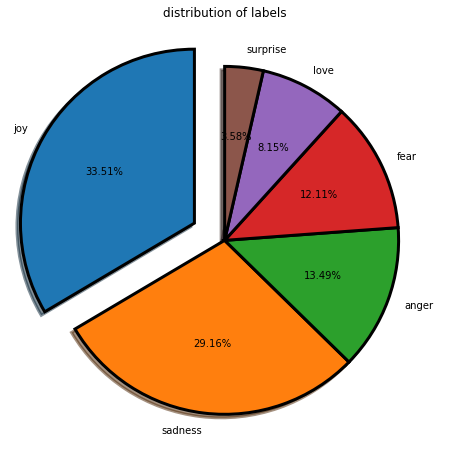

In [76]:
plt.figure(figsize=(8,8))
ex = [0.2,0,0,0,0,0]
plt.pie(values,labels=key,shadow=True,wedgeprops={'edgecolor':'k','lw':'3'},explode=ex,startangle=90,autopct='%1.2f%%')
plt.title('distribution of labels')
plt.show()

# most of the priority of joy 
# visualization of labels

In [82]:
train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## text pre-processing

In [91]:
(train['text'].map(len)).max()  # maximum length of sentence in my text

300

In [92]:
(train['text'].map(len)).min()  # minimum length of sentence in my text

7

In [107]:
(train[train['text'].map(len)==(train['text'].map(len)).min()]['text'].values)[0]  # sentence of minimum lenght


'one day'

In [108]:
(train[train['text'].map(len)==(train['text'].map(len)).max()]['text'].values)[0]  # sentence of maximum lenght


'i hope that those of you who actauly found this and read it feel possibly inspired to go out and buy some of these items or even go through storage and see what clothes of yours your mom saved and that you still have a hope of fitting in and mix up your wardrobe for this summer and have a little fun'

## i fetched the all those records which having the length greater than 50

In [54]:
final_train = train[train['text'].map(len)>50]
final_train.head()

,text,label
1,i can go from feeling so hopeless to so damned...,sadness
3,i am ever feeling nostalgic about the fireplac...,love
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear


In [55]:
train = final_train.reset_index().drop('index',axis=1)
train.head()

,text,label
0,i can go from feeling so hopeless to so damned...,sadness
1,i am ever feeling nostalgic about the fireplac...,love
2,ive been feeling a little burdened lately wasn...,sadness
3,ive been taking or milligrams or times recomme...,surprise
4,i feel as confused about life as a teenager or...,fear


In [118]:
train.shape

(12355, 2)

In [56]:
# to remove stopwords and performe stemming

ps = PorterStemmer()
for i in range(len(train)):
    content = re.sub('[^a-zA-Z]',' ',train['text'][i])
    content = content.lower()
    ls_of_word = nltk.word_tokenize(content)
    removed_stopwords = [ps.stem(word) for word in ls_of_word if word not in set(stopwords.words('english'))]
    train['text'][i] = ' '.join(removed_stopwords)
    


In [57]:
train.head()            # cleaned training data

,text,label
0,go feel hopeless damn hope around someon care ...,sadness
1,ever feel nostalg fireplac know still properti,love
2,ive feel littl burden late wasnt sure,sadness
3,ive take milligram time recommend amount ive f...,surprise
4,feel confus life teenag jade year old man,fear


In [126]:
train.head()['text'][0]    # removed stopwords and performed stemming

'go feel hopeless damn hope around someon care awak'

In [127]:
# define the vocabulary size
vocabulary_size = 10000


In [131]:
one_hoted = [one_hot(sentence,vocabulary_size) for sentence in train['text']]
one_hoted

[[8633, 5137, 6363, 3455, 7388, 107, 5135, 1516, 7541],
 [7077, 5137, 6913, 8076, 5388, 6377, 2945],
 [2415, 5137, 9670, 5494, 1763, 758, 5538],
 [2415,
  827,
  2806,
  8884,
  9444,
  5036,
  2415,
  3050,
  4672,
  3676,
  4679,
  7193,
  5137,
  5461,
  9949],
 [5137, 9884, 8540, 1116, 6545, 7122, 4909, 6797],
 [781, 7122, 5137, 781, 7446, 779, 9183, 1890, 7081],
 [5137, 5461, 4965, 7582, 7574, 2104, 7906],
 [5137, 2441, 4390, 3134, 9847, 3308, 6705, 4599],
 [9722, 1202, 8884, 7122, 5137, 9906],
 [4561,
  9790,
  1046,
  2316,
  3284,
  6296,
  9807,
  6276,
  7342,
  8884,
  515,
  8017,
  8540,
  6036,
  4905,
  6004,
  160,
  9885,
  7013,
  5137,
  9670,
  5540],
 [3350, 5137, 3953, 724, 4624, 9459, 9870, 9117, 6378, 724, 8344],
 [5137, 193, 8012, 5944, 4497, 1047, 6711, 9452],
 [5137, 6774, 6630, 5942, 8081, 9590, 3787, 9590],
 [5137,
  1983,
  304,
  9372,
  6032,
  3145,
  5137,
  4735,
  5336,
  9016,
  153,
  3734,
  5007,
  4171,
  6076,
  7052,
  7645,
  9642,
  8698],
 

In [134]:
len(one_hoted),train.shape       # smae length

(12355, (12355, 2))

In [165]:
train['text'][1]

'ever feel nostalg fireplac know still properti'

In [144]:
one_hoted[1]

[7077, 5137, 6913, 8076, 5388, 6377, 2945]

In [166]:
len(one_hoted[1])

7

In [167]:
len(train['text'][1].split())

7

In [164]:
len(new_ls[1])

7

## do pad_sequnce to equalize the shape of the sentence

In [170]:
maximum_length_of_sentence = train['text'].map(len).max()
maximum_length_of_sentence

208

In [172]:
train_data  = pad_sequences(one_hoted,padding='pre',maxlen=maximum_length_of_sentence)
train_data

array([[   0,    0,    0, ..., 5135, 1516, 7541],
       [   0,    0,    0, ..., 5388, 6377, 2945],
       [   0,    0,    0, ..., 1763,  758, 5538],
       ...,
       [   0,    0,    0, ..., 1301, 3349, 9665],
       [   0,    0,    0, ..., 5712, 3292, 5450],
       [   0,    0,    0, ..., 5137, 7963, 8308]])

In [175]:
train_data.shape         # i got  my cleaned x data and now i will labelize the y data

(12355, 208)

## to labelize the y data

In [197]:
label_encode = dict(list(zip(list(train['label'].value_counts().index),[i for i in range(0,6)])))
label_encode

{'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}

In [2]:
label_list = ['joy','sadness','anger','fear','love','surprise']
label_list

['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']

In [199]:
y = train['label'].map(label_encode)

In [200]:
y.value_counts()

0    4250
1    3443
2    1625
3    1502
4    1080
5     455
Name: label, dtype: int64

## to declare the model & compilation of the model

In [225]:
vocabulary_size,maximum_length_of_sentence

(10000, 208)

In [242]:
model  = Sequential()
model.add(Embedding(vocabulary_size,500,input_length=maximum_length_of_sentence))
model.add(Dropout(0.3))
model.add(LSTM(200))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])

In [243]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 208, 500)          5000000   
                                                                 
 dropout_12 (Dropout)        (None, 208, 500)          0         
                                                                 
 lstm_6 (LSTM)               (None, 200)               560800    
                                                                 
 dropout_13 (Dropout)        (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 5,562,006
Trainable params: 5,562,006
Non-trainable params: 0
_________________________________________________________________


In [212]:
train_data.shape

(12355, 208)

In [217]:
train_dataa = np.array(train_data)
train_dataa

array([[   0,    0,    0, ..., 5135, 1516, 7541],
       [   0,    0,    0, ..., 5388, 6377, 2945],
       [   0,    0,    0, ..., 1763,  758, 5538],
       ...,
       [   0,    0,    0, ..., 1301, 3349, 9665],
       [   0,    0,    0, ..., 5712, 3292, 5450],
       [   0,    0,    0, ..., 5137, 7963, 8308]])

In [219]:
lab  = np.array(y)
lab

array([1, 4, 1, ..., 1, 2, 1], dtype=int64)

In [222]:
lab.shape

(12355,)

In [236]:
model.fit(train_dataa,lab)       # try for one epoch

387/387 [==============================] - 374s 951ms/step - loss: 0.9950 - accuracy: 0.6274


## i got 96% percentage only in 5 epochs

In [244]:
t1 = time.time()
history = model.fit(train_dataa,lab,epochs=5,batch_size=50)
time.time()-t1



Epoch 1/5
248/248 [==============================] - 299s 1s/step - loss: 1.1158 - accuracy: 0.5849
Epoch 2/5
248/248 [==============================] - 291s 1s/step - loss: 0.2992 - accuracy: 0.9000
Epoch 3/5
248/248 [==============================] - 304s 1s/step - loss: 0.1717 - accuracy: 0.9395
Epoch 4/5
248/248 [==============================] - 296s 1s/step - loss: 0.1158 - accuracy: 0.9577
Epoch 5/5
248/248 [==============================] - 316s 1s/step - loss: 0.0861 - accuracy: 0.9681


1505.6103637218475

<AxesSubplot:>

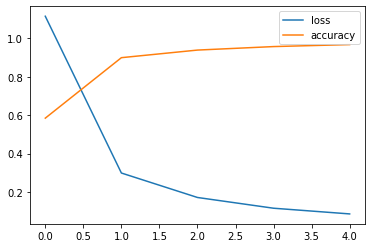

In [249]:
pd.DataFrame(model.history.history).plot()

### save the model

In [250]:
model.save('feeling.h5')

In [3]:
# load the model for evaluation
model = tf.keras.models.load_model('feeling.h5')



# this model is overfit model 

### load and prepare the test data for the testing purpose

In [58]:
with open('data/test.txt','r') as file:
    data = file.readlines()
    print(data)

['im feeling rather rotten so im not very ambitious right now;sadness\n', 'im updating my blog because i feel shitty;sadness\n', 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her;sadness\n', 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived;joy\n', 'i was feeling a little vain when i did this one;sadness\n', 'i cant walk into a shop anywhere where i do not feel uncomfortable;fear\n', 'i felt anger when at the end of a telephone call;anger\n', 'i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia;joy\n', 'i like to have the same breathless feeling as a reader eager to see what will happen next;joy\n', 'i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im

In [59]:
x2 = []
y2 = []
for i in range(len(open('data/test.txt','r').readlines())):
    splited = data[i].split(';')
    x2.append(splited[0])
    y2.append(splited[1]) 

In [60]:
x2[1]

'im updating my blog because i feel shitty'

In [61]:
y2[1]

'sadness\n'

In [29]:
len(y)

2000

In [62]:
for i in range(len(open('data/test.txt','r').readlines())):
    cleaned = y2[i].replace('\n','')
    y2[i] = cleaned

In [63]:
y2[1]

'sadness'

In [67]:
test = pd.DataFrame({'text':x2,'label':y2})
test.head()           # create data frame

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [68]:
values = list(test['label'].value_counts().values)
key = list(test['label'].value_counts().keys())

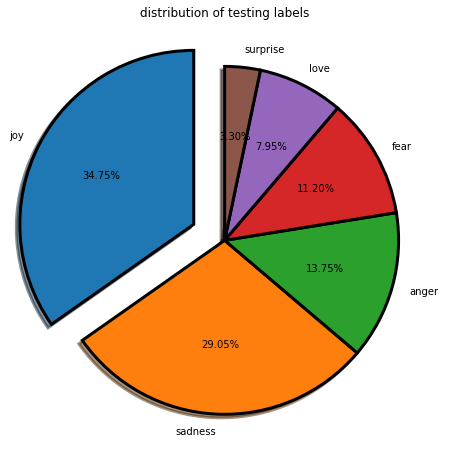

In [69]:
plt.figure(figsize=(8,8))
ex = [0.2,0,0,0,0,0]
plt.pie(values,labels=key,shadow=True,wedgeprops={'edgecolor':'k','lw':'3'},explode=ex,startangle=90,autopct='%1.2f%%')
plt.title('distribution of testing labels')
plt.show()


In [70]:
final_test = test[test['text'].map(len)>50]
final_test.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
5,i cant walk into a shop anywhere where i do no...,fear
7,i explain why i clung to a relationship with a...,joy


In [71]:
final_test.shape

(1528, 2)

In [72]:
test = final_test.reset_index().drop('index',axis=1)
test.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,i never make her separate from me because i do...,sadness
2,i left with my bouquet of red and yellow tulip...,joy
3,i cant walk into a shop anywhere where i do no...,fear
4,i explain why i clung to a relationship with a...,joy


In [73]:
# to remove stopwords and performe stemming

ps = PorterStemmer()
for i in range(len(test)):
    content = re.sub('[^a-zA-Z]',' ',test['text'][i])
    content = content.lower()
    ls_of_word = nltk.word_tokenize(content)
    removed_stopwords = [ps.stem(word) for word in ls_of_word if word not in set(stopwords.words('english'))]
    test['text'][i] = ' '.join(removed_stopwords)
    


In [74]:
test.head()

,text,label
0,im feel rather rotten im ambiti right,sadness
1,never make separ ever want feel like asham,sadness
2,left bouquet red yellow tulip arm feel slightl...,joy
3,cant walk shop anywher feel uncomfort,fear
4,explain clung relationship boy mani way immatu...,joy


In [13]:
# define the vocabulary size
vocabulary_size = 10000


## don,t confuse here train and test because i am trying to  get a generalized
### because i am cleaning again train & test data

In [14]:
one_hoted = [one_hot(sentence,vocabulary_size) for sentence in test['text']]
one_hoted

[[2101, 503, 74, 7212, 2101, 4888, 593],
 [5632, 4072, 3882, 3211, 7947, 503, 9188, 7876],
 [9835, 2965, 4256, 7853, 2112, 8890, 503, 83, 7325, 2866],
 [2809, 36, 6329, 853, 503, 4052],
 [359,
  3089,
  3860,
  1830,
  2439,
  5574,
  3844,
  1252,
  8809,
  4869,
  503,
  3805,
  4595,
  747,
  5006,
  8220,
  4034],
 [9188, 1179, 503, 6262, 7366, 2307, 4188, 9884],
 [1188, 503, 8816, 7769, 7648, 2150, 2066, 7673, 2101, 4014, 3579, 7507, 9268],
 [503, 3105, 8413, 9640, 9087, 7220, 2006, 8021, 3326, 1153],
 [4331, 4315, 6434, 503, 5628, 9931],
 [503, 4386, 2394, 1616, 8669, 5992, 6889, 8021, 9838],
 [4326, 7940, 614, 503, 2264],
 [503, 5544, 2101, 9395, 4400],
 [503, 9188, 5629, 7820, 4233, 4452, 8067, 2977],
 [503,
  330,
  7848,
  3805,
  8836,
  463,
  398,
  9104,
  1157,
  4072,
  2539,
  463,
  878,
  2060,
  9640,
  7848],
 [503, 9188, 4256, 8428, 6797, 5760, 5237],
 [2101,
  9395,
  503,
  2842,
  3211,
  9865,
  9153,
  8127,
  3098,
  118,
  503,
  6649,
  9714,
  602,
  5423

In [15]:
maximum_length_of_sentence = 208
maximum_length_of_sentence

208

In [16]:
train_data  = pad_sequences(one_hoted,padding='pre',maxlen=maximum_length_of_sentence)
train_data

array([[   0,    0,    0, ..., 2101, 4888,  593],
       [   0,    0,    0, ...,  503, 9188, 7876],
       [   0,    0,    0, ...,   83, 7325, 2866],
       ...,
       [   0,    0,    0, ..., 5674,  503, 1415],
       [   0,    0,    0, ..., 7769, 2775, 7179],
       [   0,    0,    0, ..., 4564, 4564, 3663]])

In [15]:
len(train_data[25])

208

In [17]:
label_list

['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']

In [16]:
label_encoded = {0:'joy', 1:'sadness', 2:'anger',3: 'fear', 4:'love', 5:'surprise'}
label_encoded

{0: 'joy', 1: 'sadness', 2: 'anger', 3: 'fear', 4: 'love', 5: 'surprise'}

In [46]:
train['label'][0:5]

0    sadness
1    sadness
2        joy
3       fear
4        joy
Name: label, dtype: object

In [18]:
labell = {'joy':0, 'sadness':1,'anger':2, 'fear':3, 'love':4, 'surprise':5}
labell

{'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}

In [19]:
y = train['label'].map(labell)

In [19]:
y[0:5]

0    1
1    1
2    0
3    3
4    0
Name: label, dtype: int64

In [50]:
x[1]

'im updating my blog because i feel shitty'

In [51]:
y[1]

1

### take the prediction

In [20]:
y_pred = model.predict(train_data)

48/48 [==============================] - 14s 267ms/step


In [21]:
train_data.shape          #1528 records and maximum 208 words in a sentence 

(1528, 208)

In [22]:
y_pred.shape

(1528, 6)

In [43]:
print(np.argmax(y_pred[2]))
y_pred[2]         # predicted

0


array([0.38247776, 0.04238123, 0.16509342, 0.11536489, 0.23193121,
       0.06275149], dtype=float32)

In [44]:
y[2]       # actual encoded value

0

In [45]:
label_list[y[2]]        # dctual feeling in decoded forms

'joy'

In [46]:
train.iloc[2,1]       # dctual feeling in decoded forms

'joy'

## my model was overfit because i got less accuracy on my testing data

In [42]:
model.evaluate(train_data,y)

48/48 [==============================] - 14s 265ms/step - loss: 2.4913 - accuracy: 0.2114


[2.4912877082824707, 0.21138744056224823]

## again building the model to generalize the accuracy

In [76]:
train.head()

,text,label
0,go feel hopeless damn hope around someon care ...,sadness
1,ever feel nostalg fireplac know still properti,love
2,ive feel littl burden late wasnt sure,sadness
3,ive take milligram time recommend amount ive f...,surprise
4,feel confus life teenag jade year old man,fear


In [77]:
test.head()

,text,label
0,im feel rather rotten im ambiti right,sadness
1,never make separ ever want feel like asham,sadness
2,left bouquet red yellow tulip arm feel slightl...,joy
3,cant walk shop anywher feel uncomfort,fear
4,explain clung relationship boy mani way immatu...,joy


In [80]:
train.shape

(12355, 2)

In [84]:
concat_data = pd.concat([train,test],axis=0)
concat_data.head()    # stemming performed on this data

,text,label
0,go feel hopeless damn hope around someon care ...,sadness
1,ever feel nostalg fireplac know still properti,love
2,ive feel littl burden late wasnt sure,sadness
3,ive take milligram time recommend amount ive f...,surprise
4,feel confus life teenag jade year old man,fear


In [87]:
concat_data.shape[0]

13883

In [86]:
test.shape[0]+train.shape[0]

13883

In [91]:
vocabulary_size = 10000
one_hoted = [one_hot(sentence,vocabulary_size) for sentence in concat_data['text']]
one_hoted

[[9865, 503, 8569, 3471, 8061, 4165, 3306, 8334, 8599],
 [3211, 503, 1436, 3776, 9640, 9471, 3441],
 [5250, 503, 9109, 2097, 6284, 2277, 9395],
 [5250,
  2706,
  2297,
  1613,
  3430,
  7874,
  5250,
  3960,
  9276,
  864,
  8310,
  1134,
  503,
  9188,
  8080],
 [503, 3196, 602, 6732, 8034, 3402, 1111, 5608],
 [4076, 3402, 503, 4076, 7432, 6394, 5194, 4583, 6833],
 [503, 9188, 4072, 6164, 2307, 4665, 5521],
 [503, 487, 3888, 4162, 4859, 7990, 3523, 4577],
 [5979, 2760, 1613, 3402, 503, 3497],
 [3168,
  5156,
  8013,
  9789,
  7507,
  6207,
  3747,
  3867,
  4326,
  1613,
  1607,
  7235,
  602,
  6640,
  5851,
  878,
  4632,
  3366,
  3281,
  503,
  9109,
  6999],
 [7769, 503, 1885, 2652, 2551, 6457, 3324, 7571, 4322, 2652, 2728],
 [503, 2696, 4976, 5722, 3883, 3006, 9283, 1488],
 [503, 9314, 7018, 2930, 7322, 164, 5074, 164],
 [503,
  6360,
  4839,
  9621,
  2466,
  5742,
  503,
  1812,
  4606,
  8900,
  8787,
  8260,
  6057,
  3745,
  162,
  3559,
  6299,
  2202,
  6859],
 [5639, 574

In [92]:
len(one_hoted)

13883

In [93]:
maximum_length_of_sentence = 208
data  = pad_sequences(one_hoted,padding='pre',maxlen=maximum_length_of_sentence)
data

array([[   0,    0,    0, ..., 3306, 8334, 8599],
       [   0,    0,    0, ..., 9640, 9471, 3441],
       [   0,    0,    0, ..., 6284, 2277, 9395],
       ...,
       [   0,    0,    0, ..., 5674,  503, 1415],
       [   0,    0,    0, ..., 7769, 2775, 7179],
       [   0,    0,    0, ..., 4564, 4564, 3663]])

In [102]:
dependent_var = concat_data['label'].map(labell)
dependent_var

0       1
1       4
2       1
3       5
4       3
       ..
1523    2
1524    2
1525    0
1526    0
1527    3
Name: label, Length: 13883, dtype: int64

In [103]:
data

array([[   0,    0,    0, ..., 3306, 8334, 8599],
       [   0,    0,    0, ..., 9640, 9471, 3441],
       [   0,    0,    0, ..., 6284, 2277, 9395],
       ...,
       [   0,    0,    0, ..., 5674,  503, 1415],
       [   0,    0,    0, ..., 7769, 2775, 7179],
       [   0,    0,    0, ..., 4564, 4564, 3663]])

In [108]:
dependent_var= np.array(dependent_var)
dependent_var.shape

(13883,)

In [107]:
independent_var= np.array(data)
independent_var.shape

(13883, 208)

In [109]:
dependent_var[0]

1

In [110]:
independent_var[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## this is imbalanced dataset due to this i may get the overfit problem but i don,t want
#### so first i will deal with this problem by triming the dataset

In [119]:
pd.DataFrame(y_train)[0].value_counts()        # this is imbalanced dataset

0    3854
1    3059
2    1495
3    1340
4     956
5     402
Name: 0, dtype: int64

>>## again build the model to get generalized model

In [132]:
# now i am fetching the validation data
with open('data/val.txt','r') as file:
    data = file.readlines()
    print(data)

['im feeling quite sad and sorry for myself but ill snap out of it soon;sadness\n', 'i feel like i am still looking at a blank canvas blank pieces of paper;sadness\n', 'i feel like a faithful servant;love\n', 'i am just feeling cranky and blue;anger\n', 'i can have for a treat or if i am feeling festive;joy\n', 'i start to feel more appreciative of what god has done for me;joy\n', 'i am feeling more confident that we will be able to take care of this baby;joy\n', 'i feel incredibly lucky just to be able to talk to her;joy\n', 'i feel less keen about the army every day;joy\n', 'i feel dirty and ashamed for saying that;sadness\n', 'i feel bitchy but not defeated yet;anger\n', 'i was dribbling on mums coffee table looking out of the window and feeling very happy;joy\n', 'i woke up often got up around am feeling pukey radiation and groggy;sadness\n', 'i was feeling sentimental;sadness\n', 'i walked out of there an hour and fifteen minutes later feeling like i had been beaten with a stick a

In [133]:
x3 = []
y3 = []
for i in range(len(open('data/val.txt','r').readlines())):
    splited = data[i].split(';')
    x3.append(splited[0])
    y3.append(splited[1]) 

In [134]:
for i in range(len(open('data/val.txt','r').readlines())):
    cleaned = y3[i].replace('\n','')
    y3[i] = cleaned

In [135]:
val = pd.DataFrame({'text':x3,'label':y3})
val.head()  

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [136]:
final_val = val[val['text'].map(len)>50]
final_val.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
5,i start to feel more appreciative of what god ...,joy
6,i am feeling more confident that we will be ab...,joy
7,i feel incredibly lucky just to be able to tal...,joy


In [137]:
val = final_val.reset_index().drop('index',axis=1)
val.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i start to feel more appreciative of what god ...,joy
3,i am feeling more confident that we will be ab...,joy
4,i feel incredibly lucky just to be able to tal...,joy


In [138]:
ps = PorterStemmer()
for i in range(len(val)):
    content = re.sub('[^a-zA-Z]',' ',val['text'][i])
    content = content.lower()
    ls_of_word = nltk.word_tokenize(content)
    removed_stopwords = [ps.stem(word) for word in ls_of_word if word not in set(stopwords.words('english'))]
    val['text'][i] = ' '.join(removed_stopwords)
    


In [139]:
val.head()

,text,label
0,im feel quit sad sorri ill snap soon,sadness
1,feel like still look blank canva blank piec paper,sadness
2,start feel appreci god done,joy
3,feel confid abl take care babi,joy
4,feel incred lucki abl talk,joy


In [140]:
concat_data.head()        # this is combination of traing and testing data

,text,label
0,go feel hopeless damn hope around someon care ...,sadness
1,ever feel nostalg fireplac know still properti,love
2,ive feel littl burden late wasnt sure,sadness
3,ive take milligram time recommend amount ive f...,surprise
4,feel confus life teenag jade year old man,fear


In [141]:
concat_data.shape

(13883, 2)

In [142]:
val.shape

(1538, 2)

In [146]:
all_data = pd.concat([concat_data,val],axis = 0)
all_data.head()      # all stemmed data training and testing and validation data

,text,label
0,go feel hopeless damn hope around someon care ...,sadness
1,ever feel nostalg fireplac know still properti,love
2,ive feel littl burden late wasnt sure,sadness
3,ive take milligram time recommend amount ive f...,surprise
4,feel confus life teenag jade year old man,fear


In [148]:
all_data.shape

(15421, 2)

## triming the data due to imbalanced


In [151]:
all_data['label'].value_counts()

joy         5335
sadness     4278
anger       2054
fear        1826
love        1359
surprise     569
Name: label, dtype: int64

In [155]:
len(all_data['label'].value_counts().keys())

6

In [157]:
average_data_point = int(sum(all_data['label'].value_counts().values)/len(all_data['label'].value_counts().keys()))
average_data_point

2570

In [168]:
# to handle the imbalenced data, i trimmed the entire data
joy = all_data[all_data['label']=='joy'].iloc[0:2200]
sadness = all_data[all_data['label']=='sadness'].iloc[0:2200]
anger = all_data[all_data['label']=='anger']
fear = all_data[all_data['label']=='fear']
love = all_data[all_data['label']=='love']


In [170]:
joy.shape,sadness.shape,anger.shape,fear.shape,love.shape

((2200, 2), (2200, 2), (2054, 2), (1826, 2), (1359, 2))

In [174]:
balanced_data = pd.concat([joy,sadness,anger,fear,love],axis=0)
balanced_data['label'].value_counts()

joy        2200
sadness    2200
anger      2054
fear       1826
love       1359
Name: label, dtype: int64

In [177]:
balanced_data = balanced_data.reset_index().drop('index',axis=1)
balanced_data.head()

,text,label
0,petrona year feel petrona perform well made hu...,joy
1,feel run divin experi expect type spiritu encount,joy
2,immens sympathi gener point possibl proto writ...,joy
3,abl help chai lifelin support encourag great f...,joy
4,feel superior dead chicken griev child,joy


In [210]:
values = list(balanced_data['label'].value_counts().values)
key = list(balanced_data['label'].value_counts().keys())

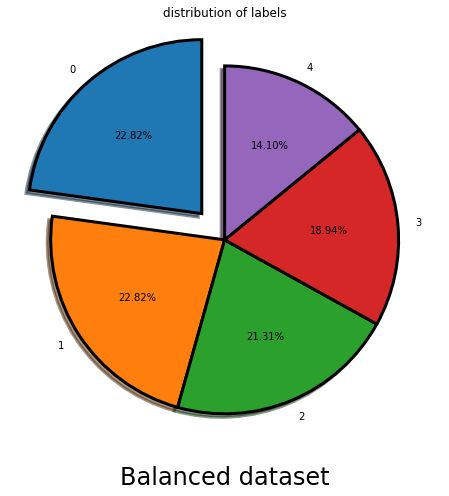

In [216]:
plt.figure(figsize=(8,8))
ex = [0.2,0,0,0,0]
plt.pie(values,labels=key,shadow=True,wedgeprops={'edgecolor':'k','lw':'3'},explode=ex,startangle=90,autopct='%1.2f%%')
plt.title('distribution of labels')
plt.xlabel('Balanced dataset',fontdict={'size':24})
plt.show()

In [178]:
balanced_data.shape

(9639, 2)

## one hot encoding

In [179]:
vocabulary_size = 20000
one_hoted = [one_hot(sentence,vocabulary_size) for sentence in balanced_data['text']]
one_hoted

[[14830, 369, 871, 14830, 6754, 7742, 4105, 1994, 7713],
 [871, 11116, 9731, 8607, 13555, 8448, 8576, 2249],
 [10022,
  10945,
  7045,
  14440,
  19480,
  8599,
  13791,
  2357,
  18016,
  10649,
  14803,
  14761,
  10914,
  11826,
  2056,
  5427,
  5372,
  17775,
  7885,
  871,
  3995,
  19413],
 [7654, 11324, 12848, 6089, 7245, 5603, 18858, 871, 2571, 7654, 11324],
 [871, 9227, 18094, 5197, 892, 11308],
 [5789, 3451, 871, 3339, 6013, 15917, 4306, 5120],
 [7052,
  6980,
  10914,
  6915,
  18386,
  15256,
  9901,
  18173,
  19098,
  871,
  17386,
  8750,
  15112,
  19460,
  8750,
  2083,
  13979,
  1864,
  4277,
  8977,
  13555,
  17742],
 [19293, 18386, 5572, 871, 7311, 18653],
 [13041, 3394, 4077, 14472, 19098, 11512, 871, 3237, 389, 2984, 2844, 2853],
 [5140, 5140, 19098, 5140, 6692, 871, 15112, 8477, 18016, 5090, 3267],
 [2526,
  3312,
  1396,
  10914,
  6703,
  6700,
  11574,
  11180,
  9212,
  418,
  3615,
  8364,
  871,
  11180],
 [13401, 18040, 14838, 18003, 12625, 871, 266, 19

In [180]:
maximum_length_of_sentence = 208
data  = pad_sequences(one_hoted,padding='pre',maxlen=maximum_length_of_sentence)
data        # this 

array([[    0,     0,     0, ...,  4105,  1994,  7713],
       [    0,     0,     0, ...,  8448,  8576,  2249],
       [    0,     0,     0, ...,   871,  3995, 19413],
       ...,
       [    0,     0,     0, ..., 14832,  5282, 17031],
       [    0,     0,     0, ...,  8202,  5432, 14624],
       [    0,     0,     0, ...,  4077,  3516, 19375]])

In [183]:
balanced_data['label'] = balanced_data['label'].map(labell)

In [187]:
x = data
y = np.array(balanced_data['label'])

In [185]:
x.shape,y.shape

((9639, 208), (9639,))

In [188]:
type(x),type(y)

(numpy.ndarray, numpy.ndarray)

In [189]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [190]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((7711, 208), (1928, 208), (7711,), (1928,))

In [192]:
pd.DataFrame(y_train)[0].value_counts()   # now i have balanced data

0    1754
1    1749
2    1651
3    1448
4    1109
Name: 0, dtype: int64

## Build the model again

In [198]:
model2  = Sequential()
model2.add(Embedding(vocabulary_size,800,input_length=maximum_length_of_sentence))
model2.add(Dropout(0.3))
model2.add(LSTM(200))
model2.add(Dropout(0.3))
model2.add(Dense(5,activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])

In [199]:
history = model2.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test),batch_size = 50)

Epoch 1/10
155/155 [==============================] - 259s 2s/step - loss: 1.1886 - accuracy: 0.5184 - val_loss: 0.5754 - val_accuracy: 0.8164
Epoch 2/10
155/155 [==============================] - 264s 2s/step - loss: 0.2963 - accuracy: 0.9021 - val_loss: 0.3351 - val_accuracy: 0.8776
Epoch 3/10
155/155 [==============================] - 263s 2s/step - loss: 0.1327 - accuracy: 0.9571 - val_loss: 0.3591 - val_accuracy: 0.8688
Epoch 4/10
155/155 [==============================] - 262s 2s/step - loss: 0.0842 - accuracy: 0.9726 - val_loss: 0.4482 - val_accuracy: 0.8615
Epoch 5/10
155/155 [==============================] - 260s 2s/step - loss: 0.0651 - accuracy: 0.9802 - val_loss: 0.5208 - val_accuracy: 0.8589
Epoch 6/10
155/155 [==============================] - 261s 2s/step - loss: 0.0407 - accuracy: 0.9885 - val_loss: 0.5086 - val_accuracy: 0.8553
Epoch 7/10
155/155 [==============================] - 259s 2s/step - loss: 0.0341 - accuracy: 0.9892 - val_loss: 0.5471 - val_accuracy: 0.8600

In [200]:
model2.save('second_model.h5')

## increase the 5 epochs from 10 to 15

In [205]:
model2.fit(x_train,y_train,initial_epoch=10,epochs=15,validation_data=(x_test,y_test),batch_size=50)

Epoch 11/15
155/155 [==============================] - 260s 2s/step - loss: 0.0419 - accuracy: 0.9873 - val_loss: 0.7335 - val_accuracy: 0.8345
Epoch 12/15
155/155 [==============================] - 262s 2s/step - loss: 0.0184 - accuracy: 0.9938 - val_loss: 0.6642 - val_accuracy: 0.8651
Epoch 13/15
155/155 [==============================] - 260s 2s/step - loss: 0.0124 - accuracy: 0.9956 - val_loss: 0.6798 - val_accuracy: 0.8605
Epoch 14/15
155/155 [==============================] - 261s 2s/step - loss: 0.0087 - accuracy: 0.9968 - val_loss: 0.7602 - val_accuracy: 0.8501
Epoch 15/15
155/155 [==============================] - 261s 2s/step - loss: 0.0051 - accuracy: 0.9982 - val_loss: 0.7910 - val_accuracy: 0.8527


In [206]:
model2.save('third_model.h5')

## again increase 3 epochs

In [207]:
model2.fit(x_train,y_train,initial_epoch=15,epochs=18,validation_data=(x_test,y_test),batch_size=50)

Epoch 16/18
155/155 [==============================] - 277s 2s/step - loss: 0.0045 - accuracy: 0.9979 - val_loss: 0.7925 - val_accuracy: 0.8558
Epoch 17/18
155/155 [==============================] - 284s 2s/step - loss: 0.0042 - accuracy: 0.9981 - val_loss: 0.8263 - val_accuracy: 0.8553
Epoch 18/18
155/155 [==============================] - 271s 2s/step - loss: 0.0048 - accuracy: 0.9979 - val_loss: 0.8894 - val_accuracy: 0.8470


In [208]:
# to get generalized model

model3  = Sequential()
model3.add(Embedding(vocabulary_size,800,input_length=maximum_length_of_sentence))
model3.add(Dropout(0.3))
model3.add(LSTM(200))
model3.add(Dropout(0.3))
model3.add(Dense(5,activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])

In [209]:
model3.fit(x_train,y_train,epochs=2,validation_data=(x_test,y_test),batch_size = 50)

Epoch 1/2
155/155 [==============================] - 266s 2s/step - loss: 1.1411 - accuracy: 0.5401 - val_loss: 0.5397 - val_accuracy: 0.8252
Epoch 2/2
155/155 [==============================] - 263s 2s/step - loss: 0.2774 - accuracy: 0.9083 - val_loss: 0.3842 - val_accuracy: 0.8610


>>>## model evaluation

### model2 evaluation

In [219]:
model2.evaluate(x_train,y_train)                 # on training data good

241/241 [==============================] - 84s 347ms/step - loss: 0.0030 - accuracy: 0.9988


[0.0029545894358307123, 0.9988328218460083]

In [220]:
model2.evaluate(x_test,y_test)                    # on testing data not good

61/61 [==============================] - 20s 334ms/step - loss: 0.8894 - accuracy: 0.8470


[0.8893616795539856, 0.8469917178153992]

### model3 evaluation

In [217]:
model3.evaluate(x_train,y_train)                 # on training data          good

241/241 [==============================] - 83s 345ms/step - loss: 0.1238 - accuracy: 0.9585


[0.12380146235227585, 0.958500862121582]

In [218]:
model3.evaluate(x_test,y_test)                    # on testing data          goood

61/61 [==============================] - 21s 342ms/step - loss: 0.3842 - accuracy: 0.8610


[0.3842027187347412, 0.8609958291053772]

In [221]:
model3.save('generalized_model.h5')

## prediction

In [222]:
y_pred = model3.predict(x_test)

61/61 [==============================] - 20s 327ms/step


In [223]:
y_pred[1]

array([9.9118453e-01, 5.9656560e-04, 1.1460446e-04, 5.0571474e-05,
       8.0536706e-03], dtype=float32)

In [224]:
resul_index = [np.argmax(sentenc) for sentenc in y_pred]
resul_index[0:5]

[3, 0, 1, 0, 2]

In [226]:
y_test[0:5]

array([3, 0, 1, 0, 2], dtype=int64)

In [230]:
accuracy_score(y_test,resul_index)

0.8609958506224067

In [235]:
print(classification_report(y_test,resul_index))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       446
           1       0.90      0.92      0.91       451
           2       0.89      0.86      0.87       403
           3       0.89      0.89      0.89       378
           4       0.69      0.89      0.78       250

    accuracy                           0.86      1928
   macro avg       0.85      0.86      0.86      1928
weighted avg       0.87      0.86      0.86      1928



In [237]:
pd.DataFrame(y_test).value_counts()

1    451
0    446
2    403
3    378
4    250
dtype: int64

In [240]:
pd.DataFrame(np.array(resul_index)).value_counts()

1    461
2    389
0    381
3    376
4    321
dtype: int64

# 😁😀 finally i built  a good model